In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, platform
sys.path.append('/Users/joewandy/work/git/vimms')
sys.path.append('/Users/joewa/work/git/vimms')
sys.path.append('/home/joewandy/vimms')

In [3]:
if platform.system() == 'Darwin':
    user = 'joewandy'
    user_vimms = '/Users/%s/Work/git/vimms' % user
    mzmine_path = '/Users/%s/MZmine-2.53-macOS/startMZmine-macOS' % user
elif platform.system() == 'Windows':
    user = 'joewa'
    user_vimms = '/Users/%s/Work/git/vimms' % user
    mzmine_path = '/Users/%s/MZmine-2.53-Windows/startMZmine-Windows.bat' % user

In [4]:
from os.path import exists
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from vimms.Evaluation import RealEvaluator
from vimms.scripts.check_ms2_matches import make_queries_from_mzml, make_queries_from_msdial, \
    make_queries_from_chemicals, library_from_msp, make_queries_from_aligned_msdial, aligned_row_to_spectral_record, \
    make_queries_from_msdial, row_to_spectral_record
from vimms.scripts.DDA_vs_DIA import get_msdial_file, match_spectra_list, evaluate_fragmentation, print_evaluations, evas_to_reports, \
    eval_res_to_df, plot_coverage_intensity_props, eva_to_matches
from vimms.Common import save_obj, set_log_level_warning, set_log_level_debug, load_obj
from mass_spec_utils.library_matching.spectrum import SpectralRecord
from vimms.Box import GenericBox, Interval, Point

In [5]:
set_log_level_warning()

1

In [6]:
min_intensity = 25000

In [7]:
output_folder = os.path.abspath('real_data_analysis_%d' % min_intensity)
output_folder

'/Users/joewandy/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofGlasgow/Vinny Davies - CLDS Metabolomics Project/DDAvsDIA/beer_analysis/real_data_analysis_25000'

# 1. Check Coverage

In [8]:
methods = [
    'topN',
    'topN_replicates',
    'topN_exclusion',
    'topN_exclusion_replicates',    
    'intensity_non_overlap',
    'intensity_non_overlap_replicates',
]
replicates = [1, 4, 1, 4, 1, 4]

In [9]:
base_dir = os.path.abspath('real_data_analysis_%d' % min_intensity)
fullscan_folder = os.path.join(base_dir, 'ground_truth_construction', 'fullscan')
fragmentation_folder = os.path.join(base_dir, 'fragmentation_files')
sample_list = ['beer1', 'beer2', 'beer3', 'beer4', 'beer5', 'beer6']
isolation_width = 0.7

In [10]:
mzmine_aligned_file = os.path.join(base_dir, 'ground_truth_construction', 'multibeers_2_aligned.csv')

fullscan_folder = os.path.join(base_dir, 'ground_truth_construction', 'fullscan')
msdial_aligned_file = get_msdial_file(fullscan_folder)
sample_col_name = 'beer'

## a. Using MS-DIAL

In [11]:
pickle_file = os.path.join(output_folder, 'msdial_eval_res.p')
if not exists(pickle_file):
    eval_using = 'msdial'
    msdial_eval_res = evaluate_fragmentation(msdial_aligned_file, eval_using, sample_col_name, 
                                             sample_list, fragmentation_folder, 
                                             methods, replicates, isolation_width)
    save_obj(msdial_eval_res, pickle_file)

## b. Using MzMine for comparison

In [12]:
pickle_file = os.path.join(output_folder, 'mzmine_eval_res.p')
if not exists(pickle_file):
    eval_using = 'mzmine'
    mzmine_eval_res = evaluate_fragmentation(mzmine_aligned_file, eval_using, sample_col_name, 
                                             sample_list, fragmentation_folder, 
                                             methods, replicates, isolation_width)
    save_obj(mzmine_eval_res, pickle_file)

# 2. Compare DDA vs DIA

## a. Load results

In [13]:
msdial_eval_res = load_obj(os.path.join(output_folder, 'msdial_eval_res.p'))
print_evaluations(msdial_eval_res)

topN
Number of fragmentations: [6439, 6477, 6440, 6480, 6471, 6391]
Cumulative coverage: [1016, 1617, 1896, 2282, 2447, 2643]
Cumulative coverage proportion: [0.1774982529699511, 0.28249475890985326, 0.3312368972746331, 0.3986722571628232, 0.4274982529699511, 0.4617400419287212]
Cumulative intensity proportion: [0.08551512855021408, 0.16132487130665754, 0.18405066662602962, 0.25234118210898243, 0.2815726640604, 0.3039049937364167]
Cumulative intensity proportion of covered spectra: [0.4817801139974659, 0.5710720861838638, 0.5556466327887097, 0.6329539554740646, 0.6586521982352799, 0.6581733576039535]
Times covered: Counter({0: 3081, 1: 1369, 2: 478, 3: 288, 4: 198, 5: 177, 6: 133})
Times fragmented: Counter({0.0: 2826, 1.0: 1291, 2.0: 550, 3.0: 310, 4.0: 229, 5.0: 175, 6.0: 126, 7.0: 59, 8.0: 49, 9.0: 28, 10.0: 19, 11.0: 9, 12.0: 9, 16.0: 6, 14.0: 5, 18.0: 4, 13.0: 3, 31.0: 2, 24.0: 2, 17.0: 2, 15.0: 2, 27.0: 1, 22.0: 1, 57.0: 1, 88.0: 1, 44.0: 1, 74.0: 1, 209.0: 1, 149.0: 1, 28.0: 1, 

In [14]:
mzmine_eval_res = load_obj(os.path.join(output_folder, 'mzmine_eval_res.p'))
print_evaluations(mzmine_eval_res)

topN
Number of fragmentations: [6439, 6477, 6440, 6480, 6471, 6391]
Cumulative coverage: [1351, 2966, 3478, 3983, 4296, 4736]
Cumulative coverage proportion: [0.2108631184641798, 0.4629311690338692, 0.5428437646324332, 0.6216638052130482, 0.6705166224442016, 0.7391915092867176]
Cumulative intensity proportion: [0.09705895137059216, 0.26069617296001857, 0.30297509086949104, 0.38389834587782906, 0.43011536848713416, 0.4798565434755214]
Cumulative intensity proportion of covered spectra: [0.4602936354044293, 0.56314240733474, 0.5581257640025385, 0.617533693708072, 0.6414686140356305, 0.6491640359053349]
Times covered: Counter({1: 2573, 0: 1671, 2: 805, 3: 441, 4: 349, 5: 317, 6: 251})
Times fragmented: Counter({0.0: 1265, 1.0: 1060, 2.0: 846, 3.0: 571, 4.0: 439, 5.0: 389, 6.0: 300, 7.0: 222, 8.0: 179, 9.0: 155, 10.0: 131, 12.0: 108, 11.0: 91, 13.0: 90, 15.0: 59, 14.0: 55, 17.0: 49, 16.0: 42, 18.0: 37, 20.0: 37, 19.0: 27, 23.0: 25, 21.0: 20, 22.0: 18, 24.0: 16, 26.0: 13, 32.0: 12, 27.0: 11

## b. Turn to dataframes

In [15]:
msdial_eval_res = load_obj(os.path.join(output_folder, 'msdial_eval_res.p'))
msdial_df = eval_res_to_df(msdial_eval_res)

topN
topN_replicates
topN_exclusion
topN_exclusion_replicates
intensity_non_overlap
intensity_non_overlap_replicates


In [16]:
mzmine_eval_res = load_obj(os.path.join(output_folder, 'mzmine_eval_res.p'))
mzmine_df = eval_res_to_df(mzmine_eval_res)

topN
topN_replicates
topN_exclusion
topN_exclusion_replicates
intensity_non_overlap
intensity_non_overlap_replicates


In [17]:
sns.set_context('poster')

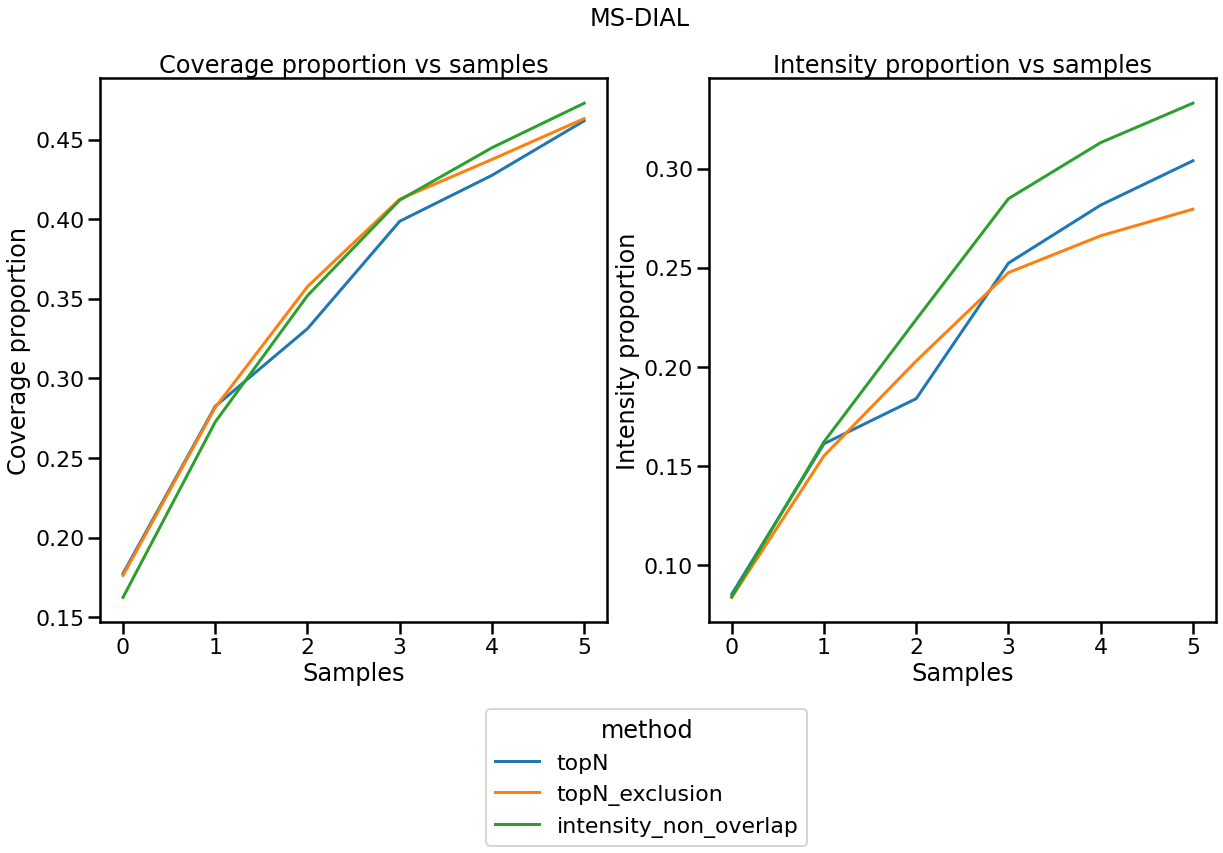

In [18]:
selected_methods = ['topN', 'topN_exclusion', 'intensity_non_overlap']
plot_coverage_intensity_props(msdial_df, selected_methods, suptitle='MS-DIAL')

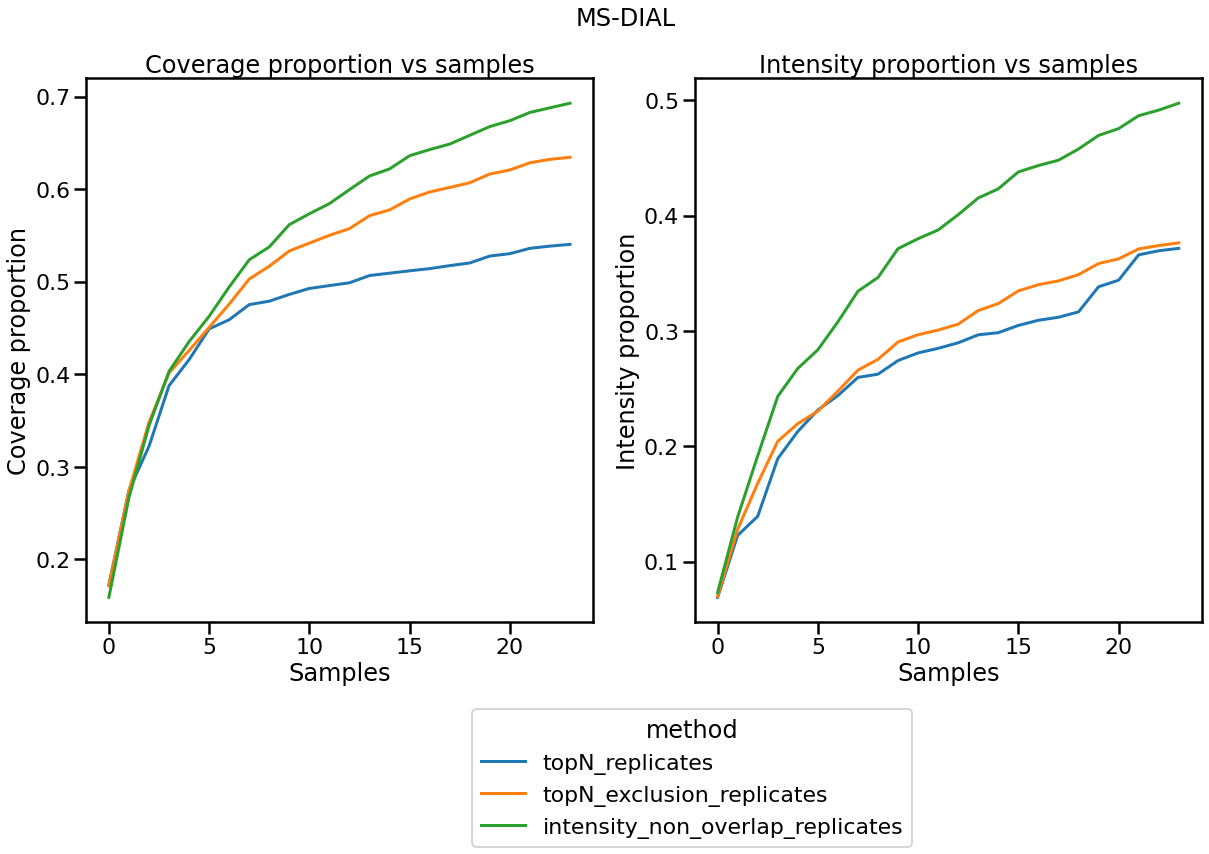

In [19]:
selected_methods = ['topN_replicates', 'topN_exclusion_replicates', 'intensity_non_overlap_replicates']
plot_coverage_intensity_props(msdial_df, selected_methods, suptitle='MS-DIAL')

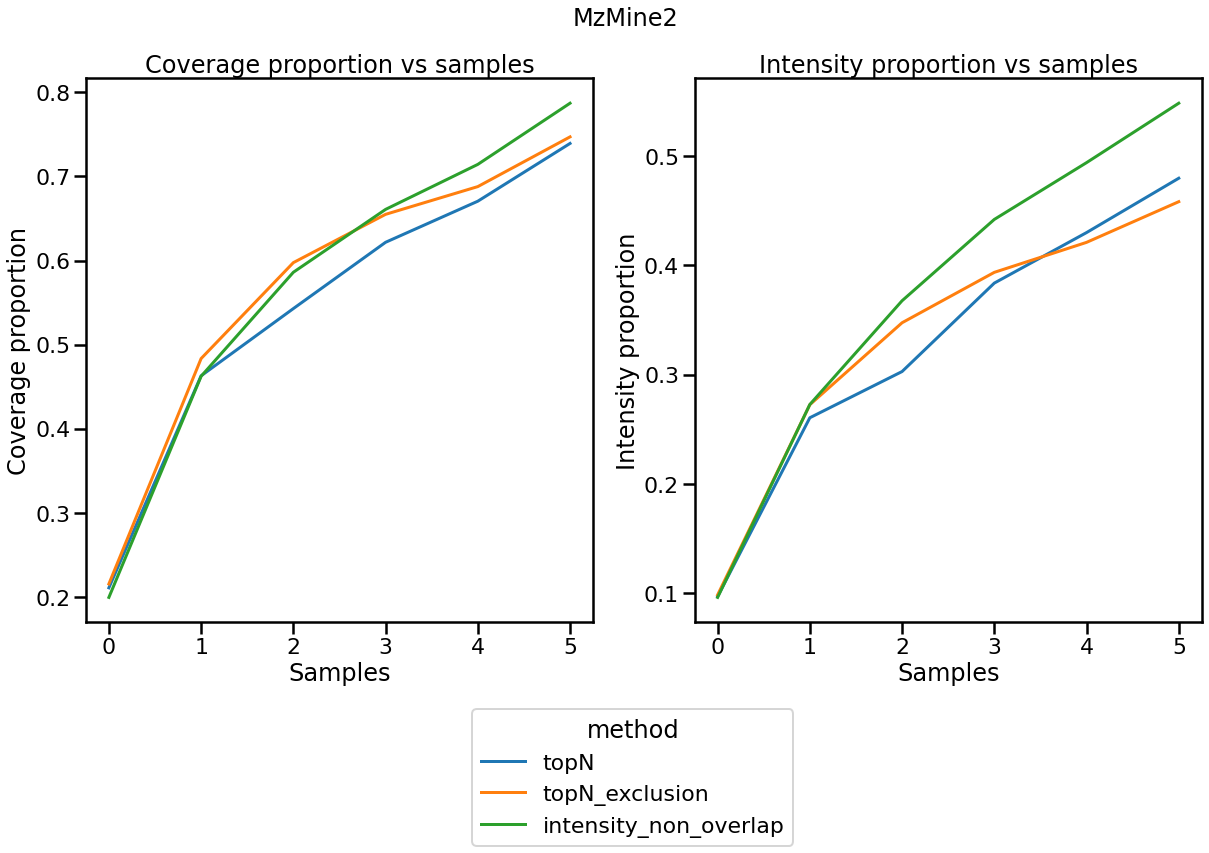

In [20]:
selected_methods = ['topN', 'topN_exclusion', 'intensity_non_overlap']
plot_coverage_intensity_props(mzmine_df, selected_methods, suptitle='MzMine2')

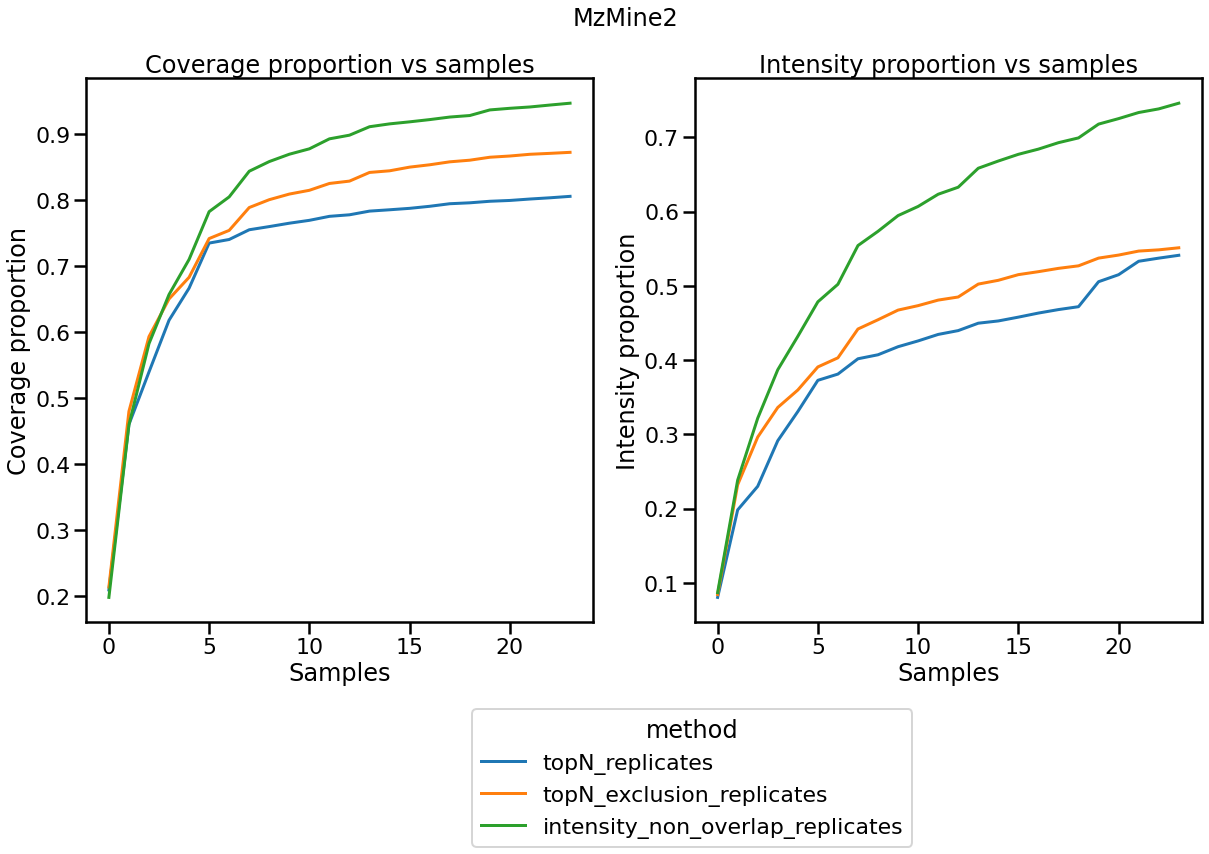

In [21]:
selected_methods = ['topN_replicates', 'topN_exclusion_replicates', 'intensity_non_overlap_replicates']
plot_coverage_intensity_props(mzmine_df, selected_methods, suptitle='MzMine2')

## c. Overall results for DDA and DIA comparisons

In [13]:
methods = [
    'topN',
    'topN_replicates',
    'topN_exclusion',
    'topN_exclusion_replicates',    
    'intensity_non_overlap',
    'intensity_non_overlap_replicates',    
    'SWATH',
    'AIF'
]
mz_tol = 5              # m/z tolerance for matching, in ppm
rt_tol = 10             # RT tolerance for matching, in seconds
allow_multiple = False  # whether to allow multiple matches for each fullscan peak
sample_name = 'beer'

In [14]:
pickle_file = os.path.join(output_folder, 'matching_df.p')
if not exists(pickle_file):
    data = []
    base_dir = os.path.abspath('real_data_analysis_%d' % min_intensity)
    fullscan_folder = os.path.join(base_dir, 'ground_truth_construction', 'fullscan')
    fullscan_file_name = get_msdial_file(fullscan_folder)
    fullscan_spectra = make_queries_from_aligned_msdial(fullscan_file_name, frag_file=False, sample_name=sample_name)

    for method in methods:
        print(method)
        fragmentation_folder = os.path.join(base_dir, 'fragmentation_files', method)

        # if AIF, SWATH then match the deconvoluted peaks to the detected peaks from the fullscan MS-DIAL results
        if method in ['AIF', 'SWATH']:        
            fragmentation_file_name = get_msdial_file(fragmentation_folder)
            fragmentation_spectra = make_queries_from_aligned_msdial(fragmentation_file_name)    
            matches = match_spectra_list(fullscan_spectra, fragmentation_spectra, 
                mz_tol, rt_tol, allow_multiple=allow_multiple)
            
        else: # otherwise directly go to the mzML file, and assign scans to detected fullscan peaks
            matches = eva_to_matches(method, msdial_eval_res, fullscan_spectra, allow_multiple=allow_multiple)
            fragmentation_spectra = [item for sublist in list(matches.values()) for item in sublist]

        out_file = os.path.join(fragmentation_folder, 'matched_spectra.p')
        save_obj(matches, out_file)

        nnz_matches = len([k for k, v in matches.items() if len(v) > 0])
        row = [
            method, 
            len(fullscan_spectra), 
            len(fragmentation_spectra), 
            nnz_matches,             
            len(fragmentation_spectra)/len(fullscan_spectra),
            nnz_matches/len(fullscan_spectra)
        ]
        print(row)
        data.append(row)

    df = pd.DataFrame(data, columns=[
        'method', 
        'num_fullscan', 
        'num_fragscan', 
        'num_matched', 
        'prop_frags_to_fullscan', 
        'prop_matched'
    ]) 
    df.to_pickle(pickle_file)

In [15]:
df = pd.read_pickle(os.path.join(output_folder, 'matching_df.p'))
df

,method,num_fullscan,num_fragscan,num_matched,prop_frags_to_fullscan,prop_matched
0,topN,6090,2895,2895,0.475369,0.475369
1,topN_replicates,6090,3450,3450,0.566502,0.566502
2,topN_exclusion,6090,3014,3014,0.494910,0.494910
3,topN_exclusion_replicates,6090,4250,4250,0.697865,0.697865
4,intensity_non_overlap,6090,3066,3066,0.503448,0.503448
5,intensity_non_overlap_replicates,6090,4591,4591,0.753859,0.753859
6,SWATH,6090,5817,3889,0.955172,0.638588
7,AIF,6090,6953,4381,1.141708,0.719376


## c. Plot matches

In [16]:
sns.set_context('poster')

In [17]:
# plt.figure(figsize=(10, 10))
# sns.barplot(data=df, x='method', hue='min_intensity', y='prop_matched')
# plt.xticks(rotation=90)

In [22]:
def plot_matched_features(df, palette=None, out_file=None):
    fig = plt.figure(figsize=(5, 5))
    
    if palette is None:
        methods = sorted(df['method'].unique())
        colours = sns.color_palette(n_colors=len(methods))
        palette = {method: colour for method, colour in zip(methods, colours)}
        palette['intensity_non_overlap_replicates'] = palette['intensity_non_overlap']
        palette['topN_exclusion_replicates'] = palette['topN_exclusion']
        palette['topN_replicates'] = palette['topN']
    
    y = 'prop_matched'
    
    # subplot 0

    selected_df = df[df['method'].isin(['topN', 'SWATH', 'AIF'])]
    line_at = selected_df[selected_df['method'] == 'topN'][y].values[0]

    g = sns.barplot(data=selected_df, x='method', y=y, palette=palette)
    g.set(ylabel='Features with \nfragmentation spectra')
    g.set(xlabel=None)
    g.set_xticklabels(['Top-N', 'SWATH', 'AIF'], rotation=0)
    # plt.title('Top-N, DIA')

#     # subplot 1

#     selected_df = df[df['method'].isin(['topN', 'topN_exclusion', 'intensity_non_overlap'])]

#     g = sns.barplot(data=selected_df, x='method', y=y, ax=axes[1], palette=palette)
#     g.set(ylabel=None)
#     g.set(xlabel=None)
#     g.set_xticklabels(['Top-N', 'Iterative\nExclusion', 'Intensity\nNon-overlap'], rotation=90)
#     axes[1].set_title('Top-N, Iterative DDA\n(1 replicate)')    
    
#     # suplot 2

#     selected_df = df[df['method'].isin(['topN_replicates', 'topN_exclusion_replicates', 'intensity_non_overlap_replicates'])]
#     selected_df = selected_df.replace({
#         'topN_replicates': 'topN',
#         'topN_exclusion_replicates': 'topN_exclusion',
#         'intensity_non_overlap_replicates': 'intensity_non_overlap'
#     })
#     g = sns.barplot(data=selected_df, x='method', y=y, ax=axes[2], palette=palette)
#     g.set(ylabel=None)
#     g.set(xlabel=None)
#     g.set_xticklabels(['Top-N', 'Iterative\nExclusion', 'Intensity\nNon-overlap'], rotation=90)

#     # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     axes[2].set_title('Top-N, Iterative DDA\n(4 replicates)')

    plt.axhline(line_at, ls='--', color='k', alpha=0.60)
    # axes[1].axhline(line_at, ls='--', color='k', alpha=0.60)
    # axes[2].axhline(line_at, ls='--', color='k', alpha=0.60)    
    # plt.suptitle(min_intensity)
    
    if out_file is not None:
        plt.savefig(out_file, dpi=300, bbox_inches="tight")
    
    return palette

In [25]:
methods = sorted(['topN', 'AIF', 'SWATH'])
colours = sns.color_palette(n_colors=len(methods))
palette = {method: colour for method, colour in zip(methods, colours)}
palette

{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}

{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}

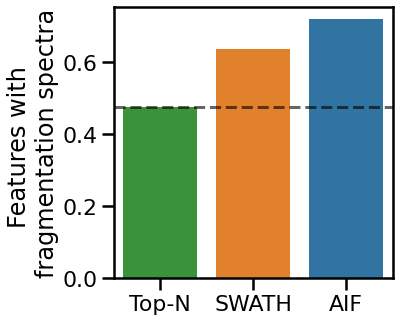

In [26]:
out_file = 'matching.png'
plot_matched_features(df, palette=palette, out_file=out_file)

# 3. Process exhaustive intensity non-overlap and turn that into ground truth

In [29]:
base_dir = os.path.abspath('real_data_analysis_%d' % min_intensity)
fullscan_folder = os.path.join(base_dir, 'ground_truth_construction', 'fullscan')
fullscan_file_name = get_msdial_file(fullscan_folder)
fullscan_spectra = make_queries_from_aligned_msdial(fullscan_file_name, frag_file=False)

In [30]:
fragmentation_folder = os.path.join(base_dir, 'fragmentation_files')
sample_list = ['beer1', 'beer2', 'beer3', 'beer4', 'beer5', 'beer6']
isolation_width = 0.7

method = 'intensity_non_overlap'
msdial_aligned_file = get_msdial_file(fullscan_folder)
sample_col_name = 'beer'
method_folder = os.path.join(base_dir, 'ground_truth_construction', method)
replicate = 10

In [31]:
pickle_file = os.path.join(output_folder, 'intensity_non_overlap_eval_res.p')
if not exists(pickle_file):
    eva = RealEvaluator.from_aligned_msdial(msdial_aligned_file, sample_col_name)
    
    mzml_pairs = []
    for sample in sample_list:
        fullscan_name = 'fullscan_%s_0' % sample
        for i in range(replicate):
            mzmls = [os.path.join(method_folder, '%s_%s_%d.mzML' % (method, sample, i))]
            pair = (fullscan_name, mzmls)
            mzml_pairs.append(pair)

    for fullscan_name, mzmls in mzml_pairs:
        print(fullscan_name, mzmls)
        eva.add_info(fullscan_name, mzmls, isolation_width=isolation_width)
        
    save_obj(eva, pickle_file)

fullscan_beer1_0 ['C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\DDAvsDIA\\beer_analysis\\real_data_analysis_25000\\ground_truth_construction\\intensity_non_overlap\\intensity_non_overlap_beer1_0.mzML']
fullscan_beer1_0 ['C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\DDAvsDIA\\beer_analysis\\real_data_analysis_25000\\ground_truth_construction\\intensity_non_overlap\\intensity_non_overlap_beer1_1.mzML']
fullscan_beer1_0 ['C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\DDAvsDIA\\beer_analysis\\real_data_analysis_25000\\ground_truth_construction\\intensity_non_overlap\\intensity_non_overlap_beer1_2.mzML']
fullscan_beer1_0 ['C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\DDAvsDIA\\beer_analysis\\real_data_analysis_25000\\ground_truth_construction\\intensity_non_overlap\\intensity_non_overlap_beer1_3.mzML']
fullscan_beer1_0 ['C:\\Users\\joewa\\Uni